# Calibration

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

#data path
cal1_path="/home/ema/Uni/LCP/LCPa_Project/180904/Run000260/data_000000.txt"

#best detectors configuration for a given run ([2,3] or [0,1]?)
calib_config=[2,3]

In [4]:
cal1={}
false_events_counter=0
with open(cal1_path) as cal1_file:
    for line in cal1_file:
        row=line.strip().split()
        key=int(row[0])
        n_hits=int(row[1])
        if n_hits!=0:
            data_array=np.array(row[2:]).reshape((n_hits, 5))
            data_dict={}
            columns=['chamber', 'layer', 'xleft', 'xright', 'time']
            for i in range(2):
                data_dict[columns[i]]=data_array[:, i].astype(int)
            for i in range(2,5):
                data_dict[columns[i]]=data_array[:, i].astype(float)
            value=pd.DataFrame(data_dict)
            cal1[key]=value
        else:
            false_events_counter+=1
original_data_length=len(cal1)+false_events_counter
print(f"null over nonnull events ratio (%) : {false_events_counter/(len(cal1)+false_events_counter)*100}%")

null over nonnull events ratio (%) : 40.931312637496944%


In [5]:
for event in cal1.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)

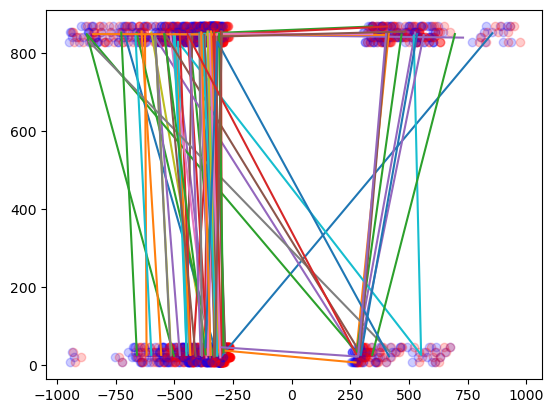

In [6]:
fig, ax=plt.subplots()
count=0
for event in cal1.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

[(2515, '[2, 3]'), (429, '[0]'), (402, '[3]'), (353, '[0, 1]'), (255, '[1]'), (250, '[0, 2, 3]'), (128, '[2]'), (110, '[0, 1, 2, 3]'), (105, '[0, 3]'), (90, '[1, 2, 3]'), (71, '[0, 1, 3]'), (55, '[1, 3]'), (28, '[0, 2]'), (24, '[1, 2]'), (18, '[0, 1, 2]')]
('[2, 3]', '[0]', '[3]', '[0, 1]', '[1]', '[0, 2, 3]', '[2]', '[0, 1, 2, 3]', '[0, 3]', '[1, 2, 3]', '[0, 1, 3]', '[1, 3]', '[0, 2]', '[1, 2]', '[0, 1, 2]') (2515, 429, 402, 353, 255, 250, 128, 110, 105, 90, 71, 55, 28, 24, 18)


Text(0.5, 1.0, 'number of events for any combination of triggered chambers')

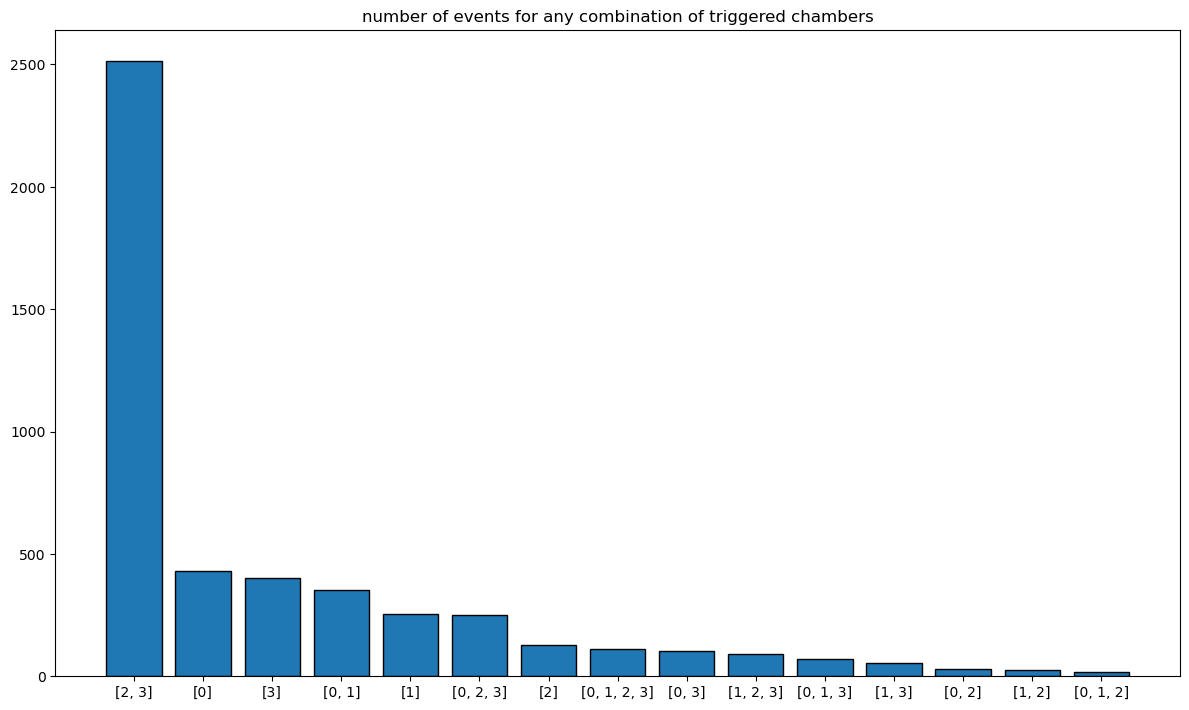

In [7]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in cal1.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_title('number of events for any combination of triggered chambers')

10.2441351888668
8



Text(0.5, 1.0, 'number of events vs number of hits for the calib_config chambers events')

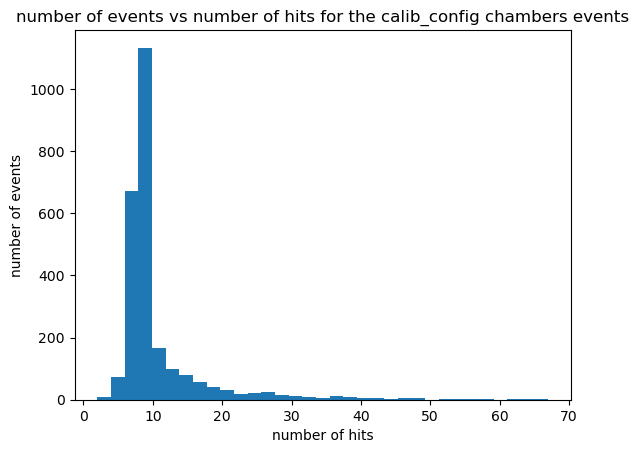

In [8]:
n_hits_per_event=[len(event) for event in cal1.values() if sorted(np.unique(event['chamber']))==calib_config]
print(np.mean(n_hits_per_event))
print(np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])])
plt.hist(n_hits_per_event, bins=33)
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title('number of events vs number of hits for the calib_config chambers events')

In [9]:
print(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))
print(cal1[4])

False
    chamber  layer    xleft  xright   time      xrg     xlg     zg
0         0      1  650.300  651.70   14.0  343.900  342.50  869.0
1         2      2  165.900  170.10   40.0 -433.300 -437.50  856.0
2         2      4  160.700  175.30  136.0 -428.100 -442.70  830.0
3         2      1  127.800  166.20  357.0 -395.200 -433.60  869.0
4         2      3  131.900  162.10  280.0 -399.300 -429.50  843.0
5         3      2   40.670   43.33   25.0 -302.170 -304.83   32.5
6         3      1   14.060   27.94  129.0 -275.560 -289.44   45.5
7         3      4   35.420   48.58  122.0 -296.920 -310.08    6.5
8         3      3   18.640   23.36   44.0 -280.140 -284.86   19.5
9         3      2   26.040   57.96  296.0 -287.540 -319.46   32.5
10        3      3    2.978   39.02  335.0 -264.478 -300.52   19.5
11        3      1   48.340   77.66  272.0 -309.840 -339.16   45.5


In [10]:
def three_layers_per_det_filter(event):
    return not np.any(np.array(event.groupby('chamber')['layer'].nunique().reset_index()['layer']<3))

impeccable_events=list(filter(lambda key : sorted(np.unique(cal1[key]['chamber']))==calib_config and three_layers_per_det_filter(cal1[key]), cal1))
print(impeccable_events)
print(f"ratio between events in [2-3] config and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between events in [2-3] config and original dataset events {len(impeccable_events)/original_data_length}")

[2, 5, 8, 11, 12, 14, 17, 21, 22, 25, 27, 35, 42, 44, 46, 47, 48, 49, 50, 51, 52, 59, 65, 66, 67, 69, 73, 80, 81, 82, 84, 88, 94, 98, 105, 108, 118, 122, 128, 130, 137, 139, 147, 148, 149, 152, 155, 164, 165, 175, 178, 180, 185, 186, 187, 190, 195, 202, 207, 216, 217, 218, 219, 225, 227, 232, 234, 242, 244, 250, 258, 260, 265, 275, 281, 283, 289, 291, 293, 294, 301, 307, 309, 313, 314, 316, 319, 326, 329, 331, 340, 341, 343, 348, 349, 353, 354, 355, 357, 360, 361, 365, 366, 367, 369, 371, 372, 374, 375, 377, 379, 384, 392, 396, 397, 401, 405, 406, 409, 418, 428, 430, 431, 439, 440, 448, 450, 454, 459, 462, 468, 475, 479, 482, 485, 486, 487, 497, 499, 501, 505, 506, 512, 518, 530, 531, 533, 537, 541, 555, 557, 560, 561, 565, 566, 569, 575, 580, 581, 583, 586, 594, 599, 601, 604, 606, 616, 622, 631, 632, 636, 637, 642, 644, 648, 650, 660, 661, 669, 672, 692, 700, 701, 702, 706, 707, 709, 713, 714, 717, 722, 726, 727, 735, 737, 738, 741, 744, 746, 750, 756, 763, 764, 766, 768, 774, 775, 7

In [11]:
print(cal1[1].groupby('chamber')['layer'].nunique().reset_index())
print(cal1[1])

   chamber  layer
0        0      3
1        3      3
   chamber  layer   xleft  xright   time     xrg     xlg     zg
0        0      4  165.60  170.40   44.0  828.60  823.80  830.0
1        0      1  101.50  108.50   65.0  892.70  885.70  869.0
2        0      2  113.10  138.90  240.0  881.10  855.30  856.0
3        3      3   20.03   21.97   18.0 -281.53 -283.47   19.5
4        3      4   28.51   55.49  250.0 -290.01 -316.99    6.5
5        3      1   11.33   30.67  180.0 -272.83 -292.17   45.5


In [98]:
from itertools import product
from scipy.stats import pearsonr
from math import atan2


def angle(A,B, C=None):
    #takes two points A and B with coordinates A=(xA,yA)... and return the angle on the plane in radiants
    #OR takes three points A, B, C with coordinates A=(xA,yA).. and return the difference angle BC^-AB^
    if C==None:
        return np.pi/2-atan2(A[1]-B[1], A[0]-B[0])
    else:
        return angle(B,C)-angle(A,B)

def zigzaginess(path):
    if(len(path)>=3):
        squaresum=0
        for i in range(len(path)-2):
            A=path[i]
            B=path[i+1]
            C=path[i+2]
            squaresum+=(angle(A,B,C))**2
        return squaresum
    else:
        print("Error: path of less than 3 points")
        return "error"

def opt_track(event, chamber):
    single_chamber=event[event['chamber']==chamber]
    single_chamber=single_chamber.sort_values(by='zg')
    axes=[['xrg', 'xlg']]*len(single_chamber)
    xcs=list(product(*axes))
    paths=[[(np.array(single_chamber[xc[i]])[i], np.array(single_chamber['zg'])[i] ) for i in range(len(single_chamber))] for xc in xcs]
    #sorting_function=(lambda path : abs(pearsonr(*zip(*path)).pvalue))
    #sorting_function=(lambda path : abs(np.corrcoef(*zip(*path))[0,1]))
    straightness_function=lambda x: -zigzaginess(x)
    best_path=max(paths, key=straightness_function)
    return best_path

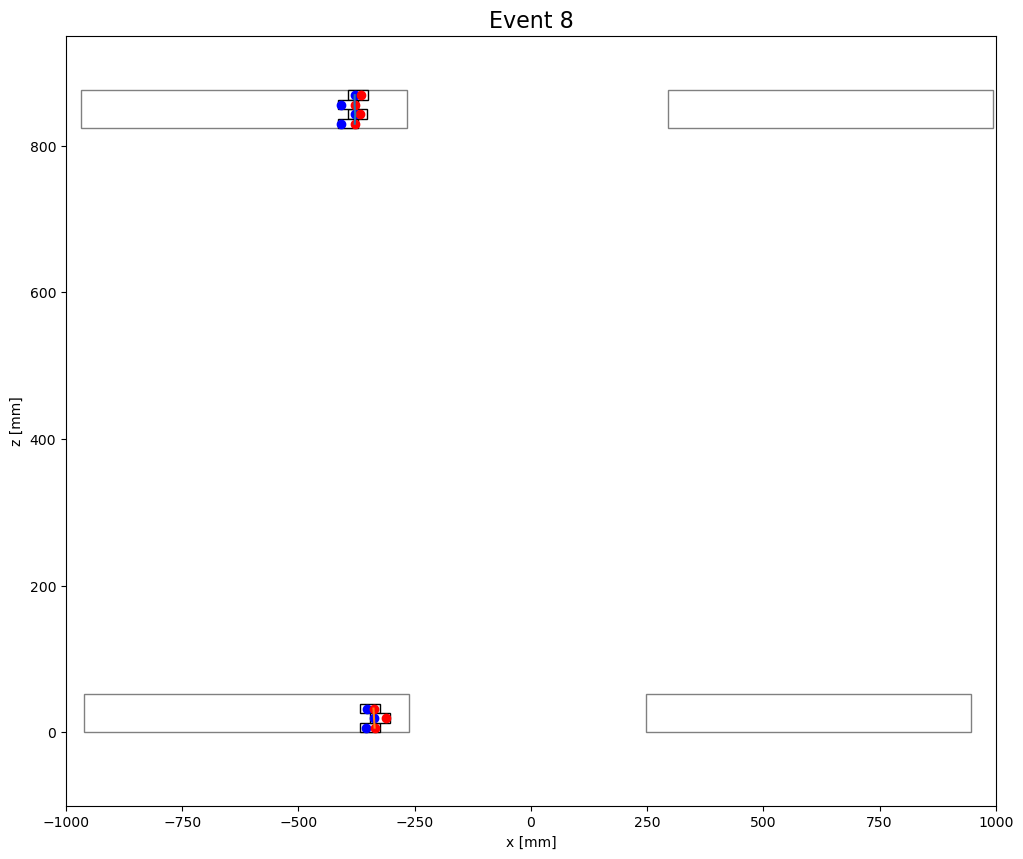

In [101]:
from matplotlib.patches import Rectangle

def event_plotter(event_number):
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    fig, ax=plt.subplots(figsize=(12,10))

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    ax.scatter(my_event['xlg'], my_event['zg'], color='blue')
    ax.scatter(my_event['xrg'], my_event['zg'], color='red')
    ax.set_xlim([-1000, 1000])
    ax.set_ylim([-100, 950])
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)

    (x,z)=zip(*opt_track(my_event, 2))
    ax.plot(x,z)
    (x,z)=zip(*opt_track(my_event, 3))
    ax.plot(x,z)

    plt.show()
    my_event

event_plotter(impeccable_events[2])
#event_plotter(4)

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory

In [68]:
event=cal1[1]
print(opt_track(event, 3))

   chamber  layer  xleft  xright   time     xrg     xlg    zg
4        3      4  28.51   55.49  250.0 -290.01 -316.99   6.5
3        3      3  20.03   21.97   18.0 -281.53 -283.47  19.5
5        3      1  11.33   30.67  180.0 -272.83 -292.17  45.5
((-290.01, -283.47, -292.17), (6.5, 19.5, 45.5))


In [ ]:
event_plotter(impeccable_events[0])